In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import math
import numpy as np

In [3]:
def saved_image(folder_name, image_name, image):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    success = cv2.imwrite(os.path.join(folder_name, image_name), image)
    if not success:
        print("Error saving image")
    print('imvrite Done')

In [4]:
import cv2
import os
import matplotlib.pyplot as plt
import math
import numpy as np

def get_countour_with_print(image, thrs):
  # image = cv2.imread(image_file)

  # if image is None:
  #     print(f"Не удалось загрузить изображение: {image_file}")
  filtered_img = cv2.blur(image, (7,7))


  filtered_img = cv2.GaussianBlur(image, (9,9), 0)
  gray_image = cv2.cvtColor(filtered_img, cv2.COLOR_BGR2GRAY)


  binary_image_adaptive = cv2.threshold(gray_image, thrs, 255, cv2.THRESH_BINARY)[1]

  # Поиск контуров
  contours, hierarchy = cv2.findContours(binary_image_adaptive, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  # Копия оригинального изображения для отображения контуров
  contour_image = image.copy()
  # Отрисовка контуров на изображении
  cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 1)
  

  approx_countours=[]
  car_number = None
  found = False
  number_file_name = ''

  for countour in contours:
    # Прямоугольник
    rect = cv2.minAreaRect(countour)
    (x, y), (w, h), angle = rect

    if angle < 45 and angle > 15:
        continue

    # Проверка на нулевую высоту или ширину
    if h == 0 or w == 0:
      continue  # Пропускаем контур, если ширина или высота равны нулю


    aspect_ratio = w / h if w > h else h / w
    area = w * h

    # Параметры для фильтрации
    if 2.5 < aspect_ratio < 5.8 and 1500 < area < 10000:

      # print('angle', angle)
      area = cv2.contourArea(countour)
      hull = cv2.convexHull(countour)
      hull_area = cv2.contourArea(hull)
      solidity = float(area)/hull_area
      # print('solidity', solidity)

      if (solidity < 0.8):
        continue
      
      box = cv2.boxPoints(rect)
      box = np.intp(box)
      approx_countours.append(box)
      angle = angle if angle < 40 else angle - 90
      # print('new_nagle', angle)
      # Вырезаем и поворачиваем ROI номерного знака
      M = cv2.getRotationMatrix2D((x, y), angle, 1.0)
      rotated = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
      #разобраться с шириной и высотой

      # Извлекаем ROI номерного знака

      vertical_value = h if w > h else w 
      gorizontal_value = w if w > h else h 

      print('vertical_value', vertical_value)
      print('gorizontal_value', gorizontal_value)

      gorizontal_value = gorizontal_value if gorizontal_value < 120 else 120

      roi = rotated[int(y - vertical_value/2):int(y + vertical_value/2), int(x - gorizontal_value/2):int(x + gorizontal_value/2)]
      # number_file_name = f'{image_file.split(".")[0]}-number.png'
      car_number = roi
      found = True
      
      plt.imshow(roi)
      plt.show()

  img_contours = image.copy()
  cv2.drawContours(img_contours, approx_countours, -1, (0, 255, 0), 1)

  return car_number, found, number_file_name

In [5]:
def get_car_number(image):
    car_number = None
    done = False
    for thrs in [90, 130, 160]:
        number, end, number_file_name = get_countour_with_print(image, thrs)
        if (end): 
            car_number = number
            done = True
            break
    return car_number, number_file_name, done

In [6]:
def split_number_by_image(image, name):
    coordinates = [
        (7,4,17,20),
        (20,4,19,21),
        (35,3,15,21),
        (50,2,15,21),
        (62,5,18,19),
        (75,5,15,19),
        (90,0,15,20),
        (100,0,15,20),
    ]
    new_symbols = []
    for i, (x, y, w, h) in enumerate(coordinates):
        symbol = image[y:y + h, x:x + w]
        folder = f'{name.split(".")[0]}'
        new_symbols.append(symbol)
        # saved_image(folder, f'symbol-{i}.png', symbol)

    cv2.destroyAllWindows()
    return new_symbols

In [7]:
def binaryzation_number_symbol(image_file): 
    # image_path = os.path.join('./01-393-number', image_file)
    # image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    image = cv2.cvtColor(image_file, cv2.COLOR_BGR2GRAY)

    equ = cv2.equalizeHist(image)
    filtered_img = cv2.GaussianBlur(equ, (3,3), 0)
    binary_image = cv2.adaptiveThreshold(filtered_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 3)
    binary_image = cv2.cvtColor(binary_image, cv2.IMREAD_GRAYSCALE)

    return image, binary_image

In [8]:
def compare_function(image_name, is_digit, is_reg = False):
    image, binary_image =binaryzation_number_symbol(image_name)
    gosznak_folder = './gosznak'
    templates = []

    # plt.imshow(binary_image)
    # plt.show()

    if is_digit:
        templates = [f for f in os.listdir(gosznak_folder) if f.endswith(('jpg', 'png', 'jpeg')) and f[0].isdigit()]
    else: 
        templates = [f for f in os.listdir(gosznak_folder) if f.endswith(('jpg', 'png', 'jpeg')) and not f[0].isdigit()]
    compares = []
    for name in templates:
        template_path = os.path.join(gosznak_folder, name)
        template = cv2.imread(template_path)
        template_gray = cv2.cvtColor(template, cv2.IMREAD_GRAYSCALE)
        assert template is not None, "file could not be read, check with os.path.exists()"

        # Изменение размера изображений
        reg_scale_factor = 0.04285714285
        scale_factor_template = 0.0488505747126437 if is_digit else 0.0599078341013825
        
        current_factor = reg_scale_factor if is_reg else scale_factor_template

        new_widts_template = int(template.shape[1] * current_factor)
        new_height_template = int(template.shape[0] * current_factor)

        template_resized = cv2.resize(template_gray, (new_widts_template,new_height_template))
        # plt.subplot(121), plt.imshow(binary_image)
        # plt.subplot(122), plt.imshow(template_resized)
        # plt.show()
        res = cv2.matchTemplate(binary_image, template_resized, cv2.TM_CCOEFF_NORMED)
        value = cv2.minMaxLoc(res)[1]
        # print('value', value, name.split('.')[0])
        compares.append((name.split('.')[0], value))
    max_val = max(compares, key=lambda tuple: tuple[1])

    template_name = [name for name in templates if name.startswith(max_val[0])][0]
    template_path = os.path.join(gosznak_folder, template_name)
    currentTemplate = cv2.imread(template_path)
    image = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)
    # plt.subplot(131), plt.imshow(image)
    # plt.subplot(132), plt.imshow(binary_image)
    # plt.subplot(133), plt.imshow(currentTemplate)
    # plt.show()
    # print(max_val[0])
    return max_val[0]

vertical_value 24.770973205566406
gorizontal_value 118.09754180908203


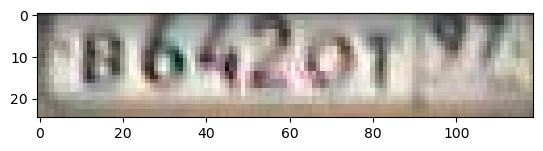

FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: './gosznak'

In [9]:
car1 = cv2.imread('cars\\01-2489.jpg')
car_test, _, _ = get_car_number(car1)
new_symbols = split_number_by_image(car_test, '')

print(compare_function(new_symbols[1],True))

# car_test, _ = get_car_number('./data/01-2060.jpg')
# new_symbols = split_number_by_image(car_test, '')
# compare_function(new_symbols[1],True)



In [10]:
def return_number(image_files):
    number = ''
    for idx, image in enumerate(image_files):
        if idx in [1,2,3]:
            number += compare_function(image, True)
        elif idx in [6,7]:
            number += compare_function(image, True, True)
        else:
            number += compare_function(image, False)
    return number

In [10]:
def get_number(image):
    car_number, name, done = get_car_number(image)
    if (done == False):
        return
    new_symbols = split_number_by_image(car_number, name)
    str_car_number = return_number(new_symbols)
    binary_images = []

    # for idx, image in enumerate(new_symbols):
    #     binary_images.append(binaryzation_number_symbol(image)[1])

    # fig, axs = plt.subplots(2, 4, figsize=(8, 8))

    # for i in range(2):
    #     for j in range(4):
    #         index = j
    #         if (i>0):
    #             index = 4+j
    #         axs[i, j].imshow(binary_images[index])
    #         axs[i, j].set_title(f'Image {index}')

    # plt.tight_layout()
    # plt.show()

    # plt.imshow(car_number)
    # plt.show()
    return str_car_number

In [12]:
# # print(get_number('./data/01-541.jpg'))
# def check_binary(image):
#     car_number, name = get_car_number(image)
#     new_symbols = split_number_by_image(car_number, name)
#     binary_images = []

#     # for idx, image in enumerate(new_symbols):
#     #     binary_images.append(binaryzation_number_symbol(image)[1])

#     # fig, axs = plt.subplots(2, 4, figsize=(8, 8))

#     # for i in range(2):
#     #     for j in range(4):
#     #         index = j
#     #         if (i>0):
#     #             index = 4+j
#     #         axs[i, j].imshow(binary_images[index])
#     #         axs[i, j].set_title(f'Image {index}')

#     plt.tight_layout()
#     plt.show()
    

In [13]:

test = cv2.imread('test.png')
print(get_number(test))
# print('------------------------------')
# print(get_number('./data/01-541.jpg'))
# print('------------------------------')
# print(get_number('./data/01-715.jpg'))
# print('------------------------------')
# print(get_number('./data/01-2060.jpg'))
# print('------------------------------')
# print(get_number('./data/01-2193.jpg'))
# print('------------------------------')
# print(get_number('./data/01-1721.jpg'))
# print('------------------------------')
# print(get_number('./data/01-2489.jpg'))
# print('------------------------------')


None


In [11]:
def get_number_binary(image):
    car_number, name = get_car_number(image)
    new_symbols = split_number_by_image(car_number, name)
    str_car_number = return_number(new_symbols)
    binary_images = []

    for idx, image in enumerate(new_symbols):
        binary_images.append(binaryzation_number_symbol(image)[1])

    fig, axs = plt.subplots(2, 4, figsize=(8, 8))

    for i in range(2):
        for j in range(4):
            index = j
            if (i>0):
                index = 4+j
            axs[i, j].imshow(binary_images[index])
            axs[i, j].set_title(f'Image {index}')

    plt.tight_layout()
    plt.show()

    # plt.imshow(car_number)
    # plt.show()
    return str_car_number

In [15]:

# print(get_number_binary('./data/01-393.jpg'))
# print('------------------------------')
# print(get_number_binary('./data/01-541.jpg'))
# print('------------------------------')
# print(get_number_binary('./data/01-715.jpg'))
# print('------------------------------')
# print(get_number_binary('./data/01-2060.jpg'))
# print('------------------------------')
# print(get_number_binary('./data/01-2193.jpg'))
# print('------------------------------')
# print(get_number_binary('./data/01-1721.jpg'))
# print('------------------------------')
# print(get_number_binary('./data/01-2489.jpg'))
# print('------------------------------')


In [16]:

# print(get_number('./data/01-2489.jpg'))
# print('------------------------------')
# print(get_number('./data/01-486.jpg'))

vertical_value 25.186479568481445
gorizontal_value 65.23506164550781


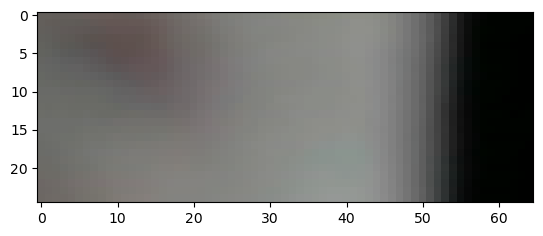

NameError: name 'return_number' is not defined

In [14]:
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Cannot open camera")
    exit()
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
 
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)


    # Display the resulting frame
    cv2.imshow('frame', gray)
    print(get_number(frame))
    if cv2.waitKey(1) == ord('q'):
        break
 
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()